# Image, Label Visualization

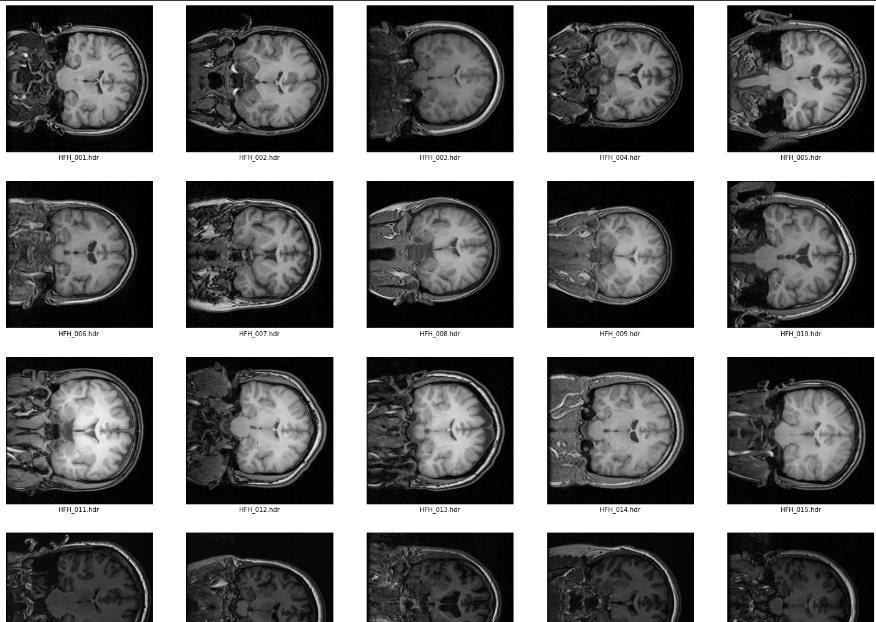

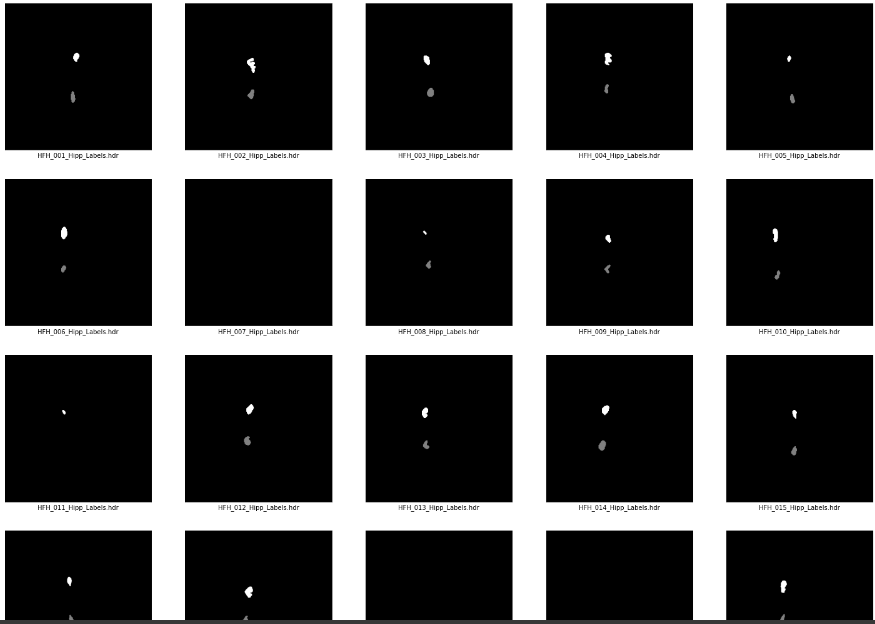

# GPU 확인

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15154237779847315777
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 23261282304
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5600467020805815775
 physical_device_desc: "device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

# Data load and preprocessing

> 보통 (124, 256)의 shape을 가진 image가 256 또는 512개 쌓여있는 3d volumne image data  
3d 형태 그대로 학습을 진행하려고 했으나 초기 환경으로는 연산량을 감당하지 못하고 계속 세션이 종료됨  
때문에 volume을 이루는 각각의 image들을 data로 사용하기로 함(25 -> 256 x 15 + 512 x 10)  
image에 대한 preprocessing은 전체 image shape을 (256, 256)으로 resize 해주었고, 픽셀값을 0~1사이로 normalization 해줌.  
label에 대한 preprocessing은 label의 픽셀값이 0, 1, 2로 되어있어 0 또는 1로 바꿈.

In [2]:
from skimage.transform import resize
import os, glob
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

In [15]:
def load_data(path, size=(256, 256), arr=True, label=False):
  # from skimage.transform import resize
  # import os, glob
  # import numpy as np
  # import nibabel as nib

  root = glob.glob(os.path.join(path, '*.hdr'))
  root.sort()

  ls = list()
  for idx, f in enumerate(root):
    hdr = nib.load(f).get_fdata()
    # print(idx+1)
    for i in hdr:
      h = resize(i, size)
      if h.max() != 0:
        h = h / h.max()
      # h = h * 256.
      ls.append(h.reshape(h.shape[0], h.shape[1]))
  
  if arr == True:
    data = np.asarray(ls)
    if label == True:
      data = np.where(data > 0, 1.0, 0.0)
    print('Done array!')
    return data

  
  else:
    print('Done image!')
    return ls
  

In [16]:
X = load_data('./dataset/Train')
y = load_data('./dataset/Train/Labels', label=True)
X_test = load_data('./dataset/Test')

Done array!
Done array!
Done array!


# Visualization

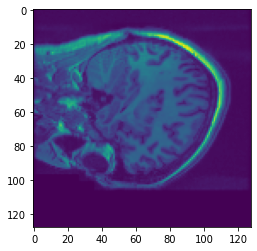

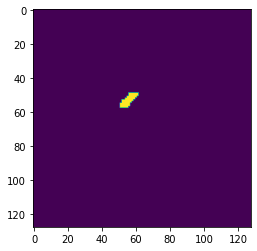

In [10]:
idx= 5700

plt.imshow(X[idx].reshape(X[idx].shape[0], X[idx].shape[1]))
plt.show()
plt.imshow(y[idx].reshape(y[idx].shape[0], y[idx].shape[1]))
plt.show()

# Train, Validation split

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [18]:
np.save(r'C:\Users\GC\Documents\hippocampus\X_train.npy', X_train)
np.save(r'C:\Users\GC\Documents\hippocampus\X_val.npy', X_val)
np.save(r'C:\Users\GC\Documents\hippocampus\y_train.npy', y_train)
np.save(r'C:\Users\GC\Documents\hippocampus\y_val.npy', y_val)
np.save(r'C:\Users\GC\Documents\hippocampus\X_test.npy', X_test)

# Visualization2

In [7]:
from ipywidgets import interact
from keras.utils import array_to_img

def browse_images(ls):
    n = len(ls)
    def view_image(i):
        plt.figure(figsize=(5, 5))
        # print(len(ls))
        img = ls[i]
        # print(img[i].shape)
        # print(img[i].reshape(img[i].shape[0],img[i].shape[1]).shape)
        # scale = img[i].shape[0] * img[i].shape[1]
        # scale = int(scale ** 0.5)
        # print(img[i].reshape(img[i].shape[0],img[i].reshape(scale, scale), cmap=plt.cm.gray))
        
        plt.imshow(ls[i].reshape(ls[i].shape[0],ls[i].shape[1])) # cmap=plt.cm.gray
        # print(img[i].reshape(img[i].shape[0],img[i].shape[1]).shape)
        plt.show()
    interact(view_image, i=(0,n-1))
  
browse_images(y_train)

interactive(children=(IntSlider(value=3583, description='i', max=7167), Output()), _dom_classes=('widget-inter…

In [19]:
print('X_train :', X_train.shape)
print('X_val   :', X_val.shape)
print('y_train :', y_train.shape)
print('y_val   :', y_val.shape)
print('X_test  :',np.array(X_test).shape)

X_train : (7168, 256, 256)
X_val   : (1792, 256, 256)
y_train : (7168, 256, 256)
y_val   : (1792, 256, 256)
X_test  : (8960, 256, 256)


# Model

* IoU : Intersection over Union. 두 집합 간의 유사도

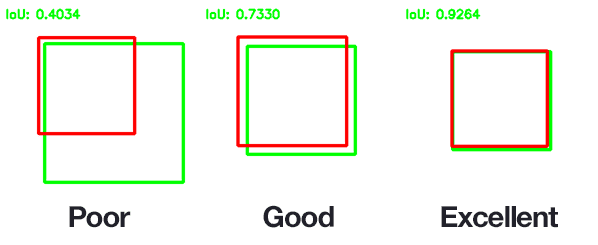

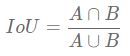

* Dice Coefficient  

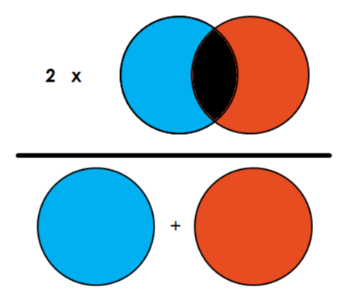

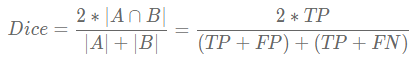

Iou와 dice coef의 차이점은 dice coef의 분모와 분자에 교집합만큼 더 더해진다는 것

In [20]:
'''
iou, dice loss function
'''

from keras import backend as K

smooth =100
def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac
    
def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [21]:
from keras.layers import *
from keras.models import Model

img_size = X_train[0].shape

def unet(pretrained_weights = None,input_size = img_size + (1,)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    bn_1 = BatchNormalization(axis=3)(conv1)
    act_1 = Activation('relu')(bn_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(act_1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    bn_2 = BatchNormalization(axis=3)(conv2)
    act_2 = Activation('relu')(bn_2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(act_2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    bn_3 = BatchNormalization(axis=3)(conv3)
    act_3 = Activation('relu')(bn_3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(act_3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    bn_4 = BatchNormalization(axis=3)(conv4)
    act_4 = Activation('relu')(bn_4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(act_4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    bn_5 = BatchNormalization(axis=3)(conv5)
    act_5 = Activation('relu')(bn_5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    bn_6 = BatchNormalization(axis=3)(conv6)
    act_6 = Activation('relu')(bn_6)
    
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv7)
    bn_7 = BatchNormalization(axis=3)(conv7)
    act_7 = Activation('relu')(bn_7)

    
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv8)
    bn_8 = BatchNormalization(axis=3)(conv8)
    act_8 = Activation('relu')(bn_8)
    
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    bn_9 = BatchNormalization(axis=3)(conv9)
    act_9 = Activation('relu')(bn_9)
    
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(act_9)

    model = model = Model(inputs=[inputs] , outputs = [conv10])    
    return model

In [22]:
unet_model = unet()
unet_model.compile(loss=dice_coef_loss, optimizer='adam', metrics=[iou, dice_coef])

In [97]:
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 256, 256, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_25 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_24[0][0]']              
                                )                                                           

Callback 정의  
Earlystopping은 사용하지 않음

In [23]:
from keras.callbacks import *

Early = EarlyStopping(patience=10, monitor='val_iou')
check = ModelCheckpoint('hippo_seg.keras', save_best_only=True, monitor='val_iou'),
reducelr = ReduceLROnPlateau(monitor='val_iou', factor=0.2, patience=5, min_lr=0.001) # 모델 학습 진전 없으면 lr을 개선시켜주는 콜백                      

Model fit

In [24]:
history = unet_model.fit(X_train, y_train,
                    epochs=300,
                    callbacks=[check, reducelr],
                    batch_size=16,
                    validation_data=(X_val, y_val))

Epoch 1/300
448/448 [==============================] - 262s 557ms/step - loss: 0.9952 - iou: 0.0026 - dice_coef: 0.0048 - val_loss: 0.9957 - val_iou: 0.0032 - val_dice_coef: 0.0043 - lr: 0.0010
Epoch 2/300
448/448 [==============================] - 245s 547ms/step - loss: 0.9594 - iou: 0.0225 - dice_coef: 0.0406 - val_loss: 0.9851 - val_iou: 0.0146 - val_dice_coef: 0.0149 - lr: 0.0010
Epoch 3/300
448/448 [==============================] - 244s 545ms/step - loss: 0.6308 - iou: 0.2509 - dice_coef: 0.3692 - val_loss: 0.7871 - val_iou: 0.1780 - val_dice_coef: 0.2129 - lr: 0.0010
Epoch 4/300
448/448 [==============================] - 244s 545ms/step - loss: 0.4335 - iou: 0.4257 - dice_coef: 0.5665 - val_loss: 0.7307 - val_iou: 0.2404 - val_dice_coef: 0.2693 - lr: 0.0010
Epoch 5/300
448/448 [==============================] - 244s 545ms/step - loss: 0.3553 - iou: 0.5078 - dice_coef: 0.6447 - val_loss: 0.6587 - val_iou: 0.3086 - val_dice_coef: 0.3413 - lr: 0.0010
Epoch 6/300
448/448 [=========

# Learning graph plot

loss와 iou에 대해 plot

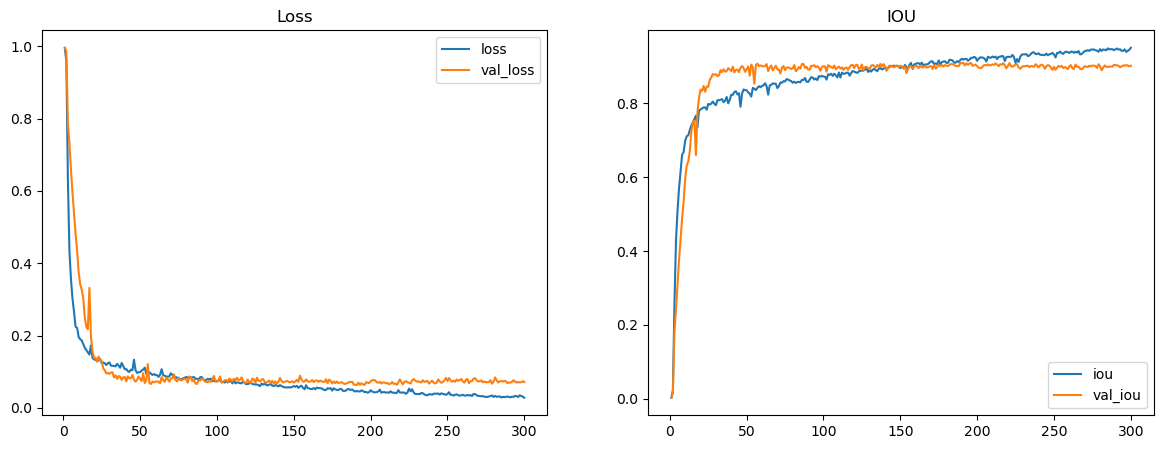

In [25]:
# acc = history.history['acc']
# val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
# mae = history.history['mae']
# val_mae = history.history['val_mae']
hiou = history.history['iou']
val_hiou = history.history['val_iou']

epoch = np.arange(1, len(loss)+1)

plt.figure(figsize=(30,5))
# plt.subplot(141)
# plt.plot(epoch, acc, label='accuracy')
# plt.plot(epoch, val_acc, label='val_accuracy')

# plt.legend()
# plt.title('Accuracy')

plt.subplot(141)
plt.plot(epoch, loss, label='loss')
plt.plot(epoch, val_loss, label='val_loss')
plt.legend()
plt.title('Loss')

# plt.subplot(143)
# plt.plot(epoch, mae, label='mae')
# plt.plot(epoch, val_mae, label='val_mae')
# plt.legend()
# plt.title('MAE')

plt.subplot(142)
plt.plot(epoch, hiou, label='iou')
plt.plot(epoch, val_hiou, label='val_iou')
plt.legend()
plt.title('IOU')

plt.show()
# print('Validation loss :', val_loss[-1])
# print('Validation accuracy :', val_acc[-1])

# Model inference by using validation set

validation dataset 중 처음 1명의 mri data에 대해 inference하기 위해 256으로 slice

In [86]:
val_mask_ls = list()

for idx, i in enumerate(X_val[:256]): # validation image
    test_image = i.reshape(X_val[idx].shape[0], X_val[idx].shape[1], 1)
    # plt.axis("off")
    # plt.imshow(array_to_img(test_image))

    val_mask = unet_model.predict(np.expand_dims(test_image, 0))[0]
    val_mask_ls.append(val_mask)

1/1 [==============================] - 0s 17ms/step


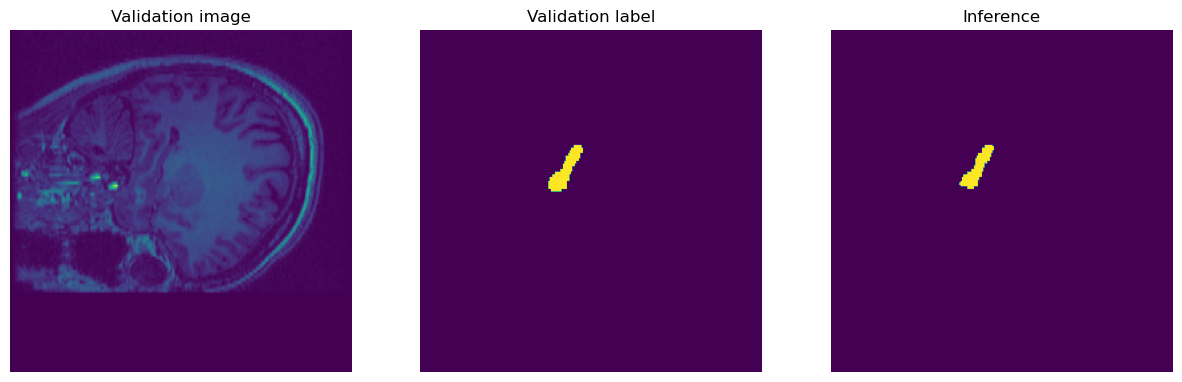

In [95]:
from keras.utils import array_to_img

# model = keras.models.load_model('/content/hippo_seg.keras')

i = 55
# test_image = X_val[i].reshape(X_test[i].shape[0], X_test[i].shape[1], 1)
# plt.axis("off")
# plt.imshow(array_to_img(test_image))

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Validation image')
test_image = X_val[i].reshape(X_test[i].shape[0], X_test[i].shape[1], 1) # validation image
plt.axis("off")
plt.imshow(array_to_img(test_image))

plt.subplot(132)

test_image = y_val[i].reshape(X_test[i].shape[0], X_test[i].shape[1], 1) # validation label
plt.title('Validation label')
plt.axis("off")
plt.imshow(array_to_img(test_image))

plt.subplot(133)
plt.title('Inference')
plt.axis('off')
test_image = val_mask_ls[i].reshape(X_test[i].shape[0], X_test[i].shape[1], 1) # model inference
plt.imshow(array_to_img(test_image))



# Model inference by using test dataset

test dataset 중 처음 1명의 mri data에 대해 inference하기 위해 256으로 slice

In [57]:
mask_ls = list()

for idx, i in enumerate(X_test[:256]): # test image
    test_image = i.reshape(X_test[idx].shape[0], X_test[idx].shape[1], 1)
    # plt.axis("off")
    # plt.imshow(array_to_img(test_image))

    mask = unet_model.predict(np.expand_dims(test_image, 0))[0]
    mask_ls.append(mask)

1/1 [==============================] - 0s 17ms/step


label을 더 잘 출력할 수 있도록 0.5를 기준으로 0과 1로 값을 나누어 정해줌

In [59]:
mask_arr = np.array(mask_ls)

tmp_ = mask_arr.copy()
tmp_[tmp_>=0.5] = 1.
tmp_[tmp_<0.5] = 0.

### Test dataset에 대한 model이 예측한 label visualization

In [72]:
# import ipywidgets as widgets
# from ipywidgets import interact
# from keras.utils import array_to_img

def browse_images(ls):
    n = len(ls)
    def view_image(i):
        plt.figure(figsize=(5, 5))
        # print(len(ls))
        img = ls[i]
        # print(img[i].shape)
        # print(img[i].reshape(img[i].shape[0],img[i].shape[1]).shape)
        # scale = img[i].shape[0] * img[i].shape[1]
        # scale = int(scale ** 0.5)
        # print(img[i].reshape(img[i].shape[0],img[i].reshape(scale, scale), cmap=plt.cm.gray))
        
        plt.imshow(ls[i].reshape(ls[i].shape[0],ls[i].shape[1])) # cmap=plt.cm.gray
        # print(img[i].reshape(img[i].shape[0],img[i].shape[1]).shape)
        plt.show()
    interact(view_image, i=(0,n-1))
  
browse_images(tmp_)

interactive(children=(IntSlider(value=127, description='i', max=255), Output()), _dom_classes=('widget-interac…

### Test image, Inference, Image + Inference

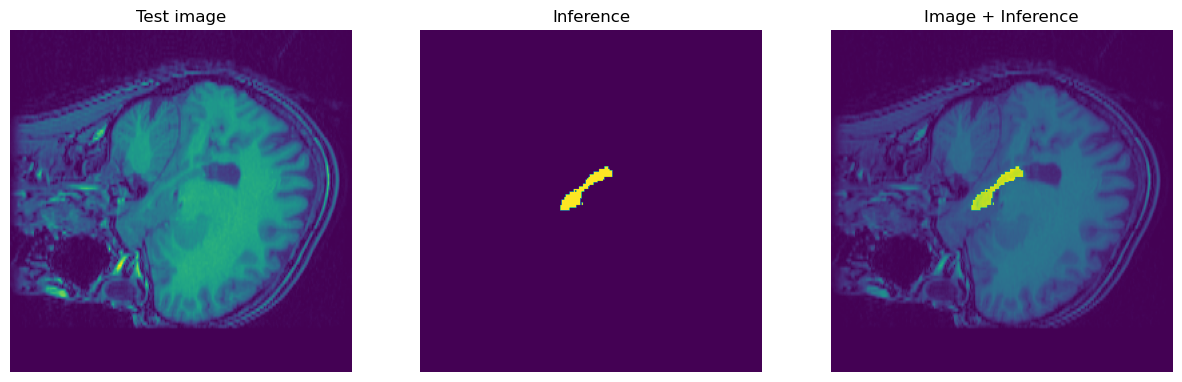

In [98]:
i = 103

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Test image')
X_test_arr = X_test[i].reshape(X_test[i].shape[0], X_test[i].shape[1], 1) # test image
plt.axis("off")
plt.imshow(array_to_img(X_test_arr))

plt.subplot(132)
plt.title('Inference')
tmp_arr = tmp_[i].reshape(X_test[i].shape[0], X_test[i].shape[1], 1) # inference
plt.axis("off")
plt.imshow(array_to_img(tmp_arr))

plt.subplot(133)
plt.title('Image + Inference')
limg = X_test_arr + tmp_arr
test_image = limg.reshape(X_test[i].shape[0], X_test[i].shape[1], 1) # image + inference
plt.axis("off")
plt.imshow(array_to_img(test_image))
